# Workshop name

**Author:** Martin Beneš, Verena Lachner

## Notebook setup

For this notebook, we will use a sample image `00001.tif` from ALASKA database. Run following code chunk to download it.

In [1]:
# download 00001.tif from ALASKA website
import requests
res = requests.get('http://alaska.utt.fr/DATASETS/ALASKA_v2_TIFF_512_COLOR/00001.tif', verify=False)
with open('00001.tif', 'wb') as f:
    f.write(res.content)

/opt/miniconda3/envs/dev/lib/python3.8/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'alaska.utt.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import scipy.stats
import seaborn as sns
import string
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
np.set_printoptions(threshold=99)
#plt.rcParams["figure.figsize"] = (12, 3)
np.random.seed(12345)  # for reproducibility
#
from matplotlib.pyplot import imshow, legend, ylim
from numpy import sum, histogram
from numpy.random import choice
from scipy.stats import chi2
from seaborn import histplot
#
im = Image.open('../img/girls.jpeg')  # load image
x = np.array(im.convert('L'))  # PIL to numpy

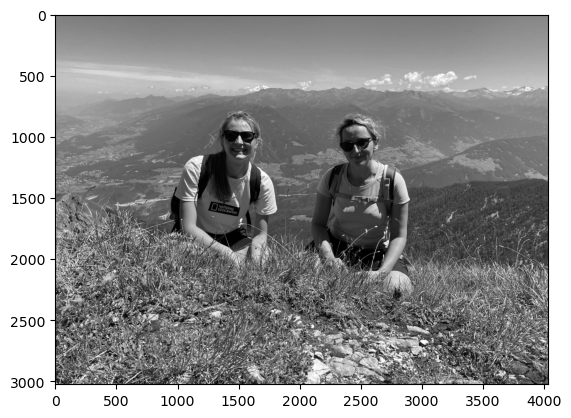

In [3]:
plt.imshow(x,cmap = "gray");

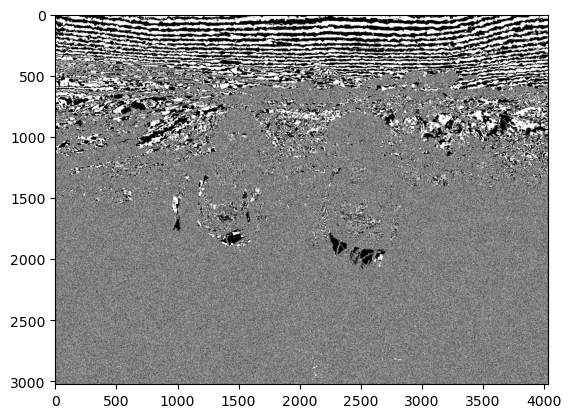

In [4]:
plt.imshow(x & 2,cmap = "gray");

## Simulated LSBr

In [5]:
alpha = .2
e = 2  # efficiency; because every other pixel is changed

### Sequential LSBr

In [6]:
payload = int(np.ceil(alpha * x.size))
probability = np.reshape([1/e]*payload + [0]*(x.size - payload), x.shape)
rng = np.random.default_rng(12345)
to_be_changed = rng.random(x.shape) < probability
print('Relative payload:', alpha)
print('Change rate:', np.mean(to_be_changed))
# modify
y = x.copy()
y[to_be_changed & (x % 2 == 0)] += 1
y[to_be_changed & (x % 2 != 0)] -= 1

Relative payload: 0.2
Change rate: 0.10005759151654489


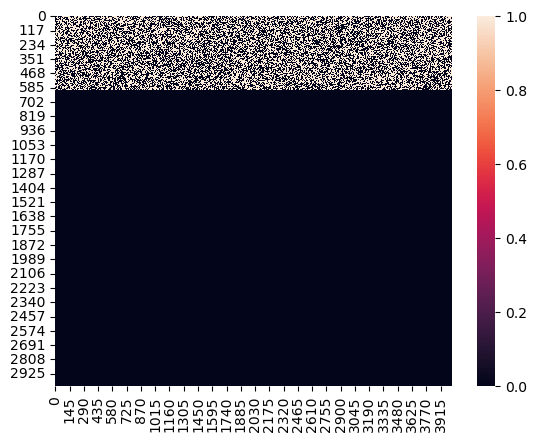

In [7]:
sns.heatmap(np.abs(y.astype('int') - x));

### Permuted LSBr

In [8]:
probability = np.ones(x.shape, dtype='float64') * alpha / e
rng = np.random.default_rng(12345)
to_be_changed = rng.random(x.shape) < probability
print('Relative payload:', alpha)
print('Change rate:', np.mean(to_be_changed))
# modify
y = x.copy()
y[to_be_changed & (x % 2 == 0)] += 1
y[to_be_changed & (x % 2 != 0)] -= 1

Relative payload: 0.2
Change rate: 0.10011590477240279


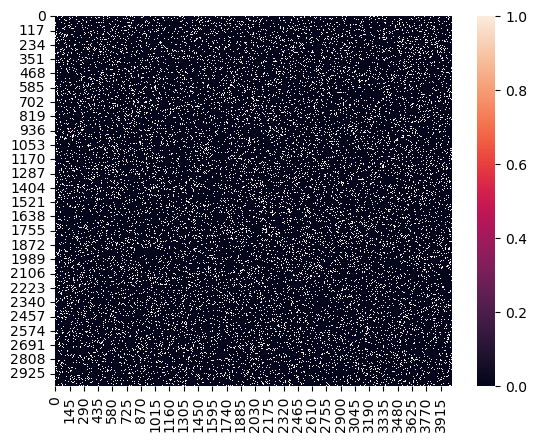

In [9]:
sns.heatmap(np.abs(y.astype('int') - x));

## Real embedding

In [10]:
# message
#message_s = 'hello!'
N = int(x.size * .5) // 8
rng = np.random.default_rng(12345)
message = ''.join(rng.choice(list(string.ascii_letters+string.digits), size=N))
len(message)

762048

In [11]:
# encode
message_bits = []
for bit in message.encode('ascii') + b'\x00':
    for i in range(8):
        message_bits.append((bit >> i) & 1)
message_bits = np.array(message_bits)
len(message_bits)
#message_bits.size / x.size

6096392

In [12]:
# set order
perm = np.linspace(0, x.size-1, x.size, dtype='int64')

## permuted walk-through
#rng = np.random.default_rng(12345)
#perm = rng.permutation(perm)

In [13]:
# iterate elements
y = x.copy()
#delta = np.zeros(x.shape, dtype='int16')
for i, it in enumerate(perm):
    # message exhausted
    if len(message_bits) <= i:
        break
        
    # get index
    idx = it // x.shape[1], it % x.shape[1]
    
    # make change
    y[idx] &= ~0 << 1
    y[idx] |= message_bits[i]
    #delta[idx] = (message_bits[i] - x[idx] % 2)

In [14]:
np.mean(x != y)

0.24996489722432183

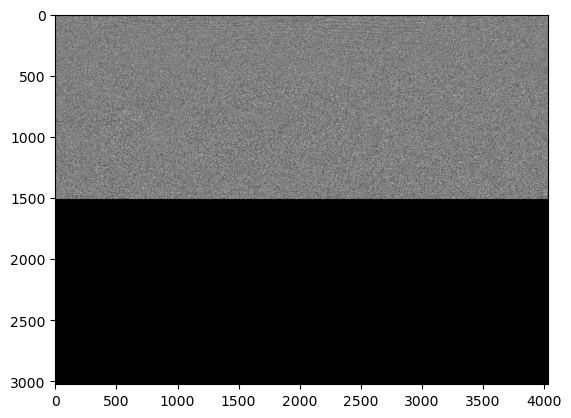

In [15]:
plt.imshow(x != y, vmin=0, vmax=1, cmap='gray');

In [16]:
# iterate elements
message_bits2 = []
for i, it in enumerate(perm):
    # get index
    idx = it // y.shape[1], it % y.shape[1]
        
    # get message bit
    message_bits2.append(y[idx] & 1)

    # check end
    if (i + 1) % 8 == 0:
        if all([b == 0 for b in message_bits2[-8:]]):
            break

In [17]:
# iterate characters
message_b = b''
for i in range(len(message_bits2)//8):
    char_bits = list(message_bits2[i*8:(i+1)*8])

    # decode the byte
    byte = 0
    for i, bit in enumerate(char_bits):
        byte |= bit << i
    message_b += int(byte).to_bytes(1, byteorder='big')

# remove tracing zero
message2 = bytes.decode(message_b, 'ascii').split('\0')[0]
len(message2)

762048

In [18]:
message == message2

True